<a href="https://colab.research.google.com/github/jklbpl/Conformal/blob/main/regression_nonconf_signerror.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install nonconformist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for nonconformist: filename=nonconformist-2.1.0-py3-none-any.whl size=17840 sha256=45c97767ad1fa27a8aaaba7e3790c3298378ed26774bab5edf873a531b1c599a
  Stored in directory: /root/.cache/pip/wheels/87/01/fa/9e7ef08e0d6dbdab8e37671b66f4b81e6c41423f9084249675
Successfully built nonconformist


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_diabetes
from nonconformist.nc import SignErrorErrFunc, AbsErrorErrFunc
from sklearn.ensemble import RandomForestRegressor
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory

In [6]:
#data_data, data_target = fetch_california_housing(return_X_y= True)
data_data, data_target = load_diabetes(return_X_y= True)
df_features = pd.DataFrame(data_data)
df_target = pd.DataFrame(data_target)
idx_size = df_target.size

np.random.seed(2)

idx = np.random.permutation(len(data_data))

# test = 10%, test(test+calib) = 90% (80%+20%)
test_size = int(idx_size  * 0.1)
train_size = idx_size  - test_size
calib_size = int(train_size * 0.2)
train_size = train_size - calib_size

idx_train, idx_cal, idx_test = idx[:train_size], idx[train_size:train_size + calib_size], idx[train_size + calib_size:]


print('Test size: {}'.format(test_size))
print('Calibration size: {}'.format(calib_size))
print('Train size: {}'.format(train_size))


Test size: 44
Calibration size: 79
Train size: 319


In [7]:
significance = 0.05

In [8]:
model = RandomForestRegressor()	# Create the underlying model

nc_sign = NcFactory.create_nc(model,err_func = SignErrorErrFunc())	# Create a default nonconformity function
icp_sign = IcpRegressor(nc_sign)			# Create an inductive conformal regressor

# Fit the ICP using the proper training set
icp_sign.fit(data_data[idx_train, :], data_target[idx_train])

# Calibrate the ICP using the calibration set
icp_sign.calibrate(data_data[idx_cal, :], data_target[idx_cal])

# Produce predictions for the test set, with confidence 95%
prediction_sign = icp_sign.predict(data_data[idx_test, :], significance=0.05)

# Print the first 5 predictions
print(prediction_sign[:5, :])

[[ 49.04 255.71]
 [ 15.96 222.63]
 [ 88.44 295.11]
 [-25.42 181.25]
 [107.66 314.33]]


In [9]:
predictions_cal = model.predict(data_data[idx_cal,:])
predictions_test = model.predict(data_data[idx_test,:])

In [10]:
def sign_error(prediction_set, y):
  return (prediction_set - y)
  
def sign_error_inv(cal_score, significance, sign_is_nondef):
  if sign_is_nondef is False:
    cal_scores_sorted = np.sort(cal_score)[::-1]
    quantile_significance_up = np.quantile(cal_scores_sorted, significance/2)
    quantile_significance_low = np.quantile(cal_scores_sorted, 1-significance/2)

    cal_scores_sorted_bool_up = cal_scores_sorted <= quantile_significance_up
    for i in range(len(cal_scores_sorted)):
      if cal_scores_sorted_bool_up[i]:
        number_up = i

    cal_scores_sorted_bool_low = cal_scores_sorted <= (quantile_significance_low)
    for j in range(0,len(cal_scores_sorted)):
      if cal_scores_sorted_bool_low[j]:
        number_low = j
        return cal_scores_sorted[number_low],-cal_scores_sorted[number_up]
  
  if sign_is_nondef is True:
    nc = np.sort(cal_score)[::-1]
    upper = int(np.floor((significance / 2) * (nc.size + 1)))
    lower = int(np.floor((1 - significance / 2) * (nc.size + 1)))
    upper = min(max(upper, 0), nc.size - 1)
    lower = max(min(lower, nc.size - 1), 0)
    return np.vstack([-nc[lower], nc[upper]])

In [11]:
cal_scores_sign = sign_error(predictions_cal, data_target[idx_cal])

intervals_sign = np.zeros((idx_test.size, 2))
cal_scores_sign_sorted = np.sort(cal_scores_sign)[::-1]
border_low, border_up = sign_error_inv(cal_scores_sign, significance, sign_is_nondef = False)
intervals_sign[:, 0] = predictions_test - border_up
intervals_sign[:, 1] = predictions_test + border_low

print(np.sum(intervals_sign != prediction_sign))

0


In [13]:
prediction_nondef = icp_sign.predict(data_data[idx_test, :])

In [14]:
significance_nondefined = np.arange(0, 1, 0.01)
intervals_none = np.zeros((idx_test.size, 2, (significance_nondefined.size)))
norm = np.ones(int(idx_test.size))
for i, j in enumerate(significance_nondefined):

  err_dist = sign_error_inv(cal_scores_sign, j, sign_is_nondef = True)
  err_dist = np.hstack([err_dist] * idx_test.size)
  err_dist *= norm

  intervals_none[:, 0, i] = predictions_test - err_dist[0, :]
  intervals_none[:, 1, i] = predictions_test + err_dist[0, :]


  #border_low_nondefsign, border_up_nondefsign  = sign_error_inv(cal_scores_sign, j)
  #intervals_none[:, 0, i] = predictions_test - border_up_nondefsign
  #intervals_none[:, 1, i] = predictions_test + border_low_nondefsign
  #print("lower border: {}, \n upper_border: {}\n".format(border_low_nondefsign,border_up_nondefsign))

print(np.sum(prediction_nondef[:,:,:] != intervals_none[:,:,:]))
#print(np.max(np.abs(prediction_nondef - intervals_none[:,:,:99])))

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Text(0.5, 1.0, 'Distribution of border values')

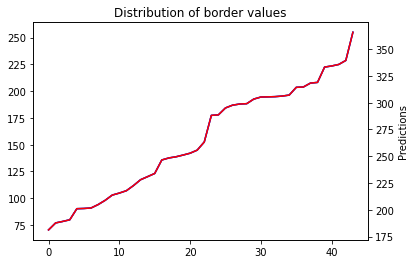

In [15]:
plt.plot(np.sort(predictions_test))
plt.twinx()
plt.plot(np.sort(intervals_sign[:,1]), color='b', linestyle='-')
plt.plot(np.sort(prediction_sign[:,1]), color='r', linestyle='-')
plt.ylabel('Predictions')
plt.title('Distribution of border values')